In [1]:
from qiskit import QuantumCircuit
from Functions.helpers import *
from Functions.Key_Generate import *
from Functions.Arithmetics import *
from Functions.Subnibble import *
from Functions.SwapRow_and_MixColumn import *
SAES_GATE_LOG = []
key = []

In [2]:
plaintext = '1001011011001111'   # 16 bits
round_key = '1010011100111011'   # 16 bits (if needed)

total_qubits = 48
qc = QuantumCircuit(total_qubits, 16)

# Generate Round Keys for all Stages 
K = generate_round_keys(round_key)

# place plaintext on 0..15
apply_plaintext(qc,
                plaintext)
log_gate_stats("Plaintext",
               qc,
               SAES_GATE_LOG)

# Add round key to Plain text 
add_round_key(qc,
              K[0])

log_gate_stats("RoundKey 0",
               qc,
               SAES_GATE_LOG)

# ------------------------------
# Round 1
# ------------------------------
# Subnibble 1
apply_subnibbles_round(
    qc,
    state_base=0,
    workspace_base=32
)
log_gate_stats("SubNibble 1",
               qc,
               SAES_GATE_LOG)

# Swap row needs no gates. Swap function performed inside Mixcolumn
log_gate_stats("SwapRow 1",
               qc,
              SAES_GATE_LOG)
    
# Swap Row 1 + Mixcolumns1:
apply_mixcolumns_stage(qc,
                       state_base=0,
                       workspace_base=32,
                       reset_workspace=True,
                       draw_mode=None)

log_gate_stats("MixColumn 1",
               qc,
              SAES_GATE_LOG)
    
# add round key 1
add_round_key(qc,
              K[1])

log_gate_stats("RoundKey 1",
               qc,
               SAES_GATE_LOG)

# ------------------------------
# Round 2
# ------------------------------
# Subnibble 2
apply_subnibbles_round(
    qc,
    state_base=0,
    workspace_base=32
)
log_gate_stats("SubNibble 2",
               qc,
               SAES_GATE_LOG)

# Swap row needs no gates. Swap function performed inside Mixcolumn
log_gate_stats("SwapRow 2",
               qc,
              SAES_GATE_LOG)
   
# Swap Row 2 + Mixcolumns2:
apply_mixcolumns_stage(qc,
                       state_base=0,
                       workspace_base=32,
                       reset_workspace=True,
                       draw_mode=None)
log_gate_stats("MixColumn 2",
               qc,
               SAES_GATE_LOG)

# add round key 2
add_round_key(qc,
              K[2])
log_gate_stats("Roundkey 3",
               qc,
               SAES_GATE_LOG)


[LOG] Recorded stage 'Plaintext'  → total gates = 10, depth = 1
[LOG] Recorded stage 'RoundKey 0'  → total gates = 36, depth = 2
[LOG] Recorded stage 'SubNibble 1'  → total gates = 420, depth = 199
[LOG] Recorded stage 'SwapRow 1'  → total gates = 420, depth = 199
[LOG] Recorded stage 'MixColumn 1'  → total gates = 488, depth = 209
[LOG] Recorded stage 'RoundKey 1'  → total gates = 511, depth = 209
[LOG] Recorded stage 'SubNibble 2'  → total gates = 895, depth = 405
[LOG] Recorded stage 'SwapRow 2'  → total gates = 895, depth = 405
[LOG] Recorded stage 'MixColumn 2'  → total gates = 963, depth = 415
[LOG] Recorded stage 'Roundkey 3'  → total gates = 987, depth = 415


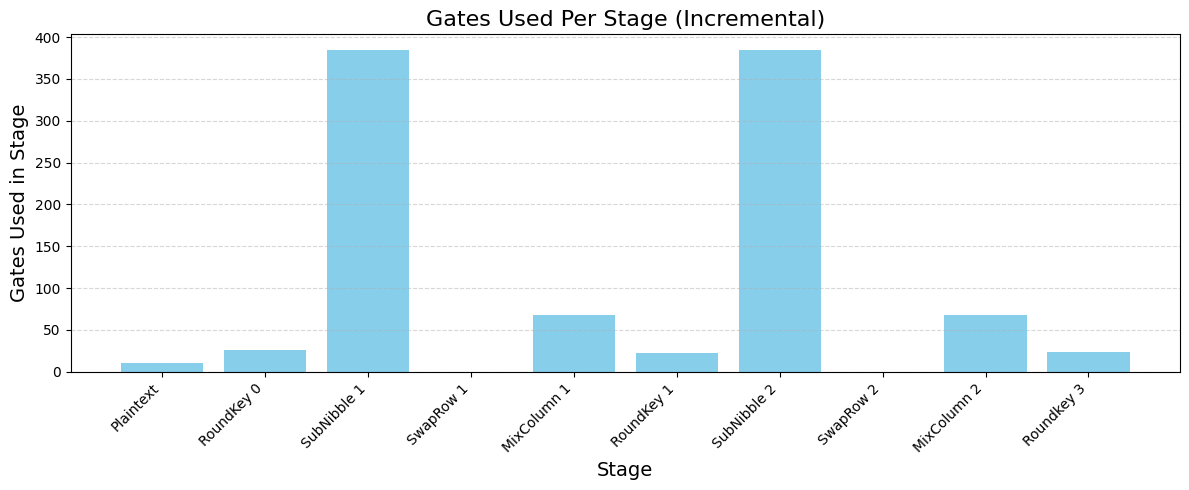

[10, 26, 384, 0, 68, 23, 384, 0, 68, 24]


In [3]:
import matplotlib.pyplot as plt

def plot_gate_usage_per_stage(log):
    """
    Given SAES_GATE_LOG, compute (current - previous)
    and plot a bar chart of gates *used in each stage*.
    """

    stages = [entry['stage'] for entry in log]
    totals  = [entry['total_gates'] for entry in log]

    # Compute per-stage usage
    per_stage = []
    for i in range(len(totals)):
        if i == 0:
            per_stage.append(totals[i])  # first stage
        else:
            per_stage.append(totals[i] - totals[i-1])

    # Bar chart
    plt.figure(figsize=(12, 5))
    plt.bar(stages, per_stage, color='skyblue')

    plt.xticks(rotation=45, ha='right')
    plt.title("Gates Used Per Stage (Incremental)", fontsize=16)
    plt.xlabel("Stage", fontsize=14)
    plt.ylabel("Gates Used in Stage", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    return per_stage


per_stage_gates = plot_gate_usage_per_stage(SAES_GATE_LOG)
print(per_stage_gates)

In [4]:
# Measure final ciphertext (state qubits 0..15)
qc_final = qc.copy()
qc_final.measure(list(range(16)), list(range(16)))

In [10]:
from qiskit_aer import AerSimulator
backend = AerSimulator(method="extended_stabilizer")

result = backend.run(qc_final, shots=1).result()
ciphertext = list(result.get_counts().keys())[0]

print("Ciphertext:", ciphertext)
print("Plaintext:", plaintext)

Ciphertext: 0001100111001001
Plaintext: 1001011011001111
